In [1]:
# Celda 1

import pandas as pd                   # Importa la librería pandas para la manipulación de estructuras de datos (DataFrames)
import numpy as np                    # Importa numpy para operaciones numéricas y manejo de arrays
import matplotlib.pyplot as plt       # Importa matplotlib para la creación de gráficos
import yfinance as yf                 # Importa yfinance para descargar datos financieros desde Yahoo Finance
from statsmodels.tsa.seasonal import seasonal_decompose  # Importa la función para descomponer series de tiempo
from statsmodels.tsa.arima.model import ARIMA            # Importa el modelo ARIMA para análisis y predicción de series
import seaborn as sns  # Seaborn maneja los estilos de Matplotlib
sns.set_style("darkgrid")  # Aplica un estilo de cuadrícula oscura



In [2]:
# Celda 2

# Definimos el símbolo y el rango de fechas para descargar los datos
ticker_symbol = 'AAPL'                # Símbolo de la acción de Apple
start_date = '2020-01-01'             # Fecha de inicio para la descarga de datos
end_date = '2022-12-31'               # Fecha de finalización para la descarga de datos

# Descargamos los datos históricos de AAPL y los almacenamos en un DataFrame
df = yf.download(ticker_symbol, start=start_date, end=end_date)  # Función que descarga los datos de Yahoo Finance

# Mostramos las primeras 5 filas del DataFrame para verificar su contenido
df.head()                             # Imprime las primeras 5 filas del DataFrame


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716064,72.776591,71.466805,71.721011,135480400
2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800
2020-01-06,72.582916,72.621654,70.876083,71.127873,118387200
2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000
2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200


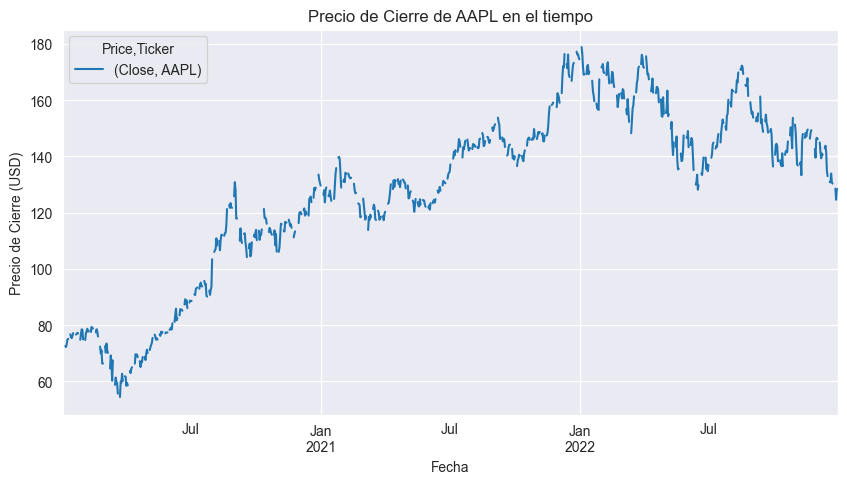

In [3]:
# Celda 3

# Verificamos que el DataFrame `df` ha sido cargado correctamente
if 'df' not in locals():
    raise ValueError("El DataFrame 'df' no está definido. Asegúrate de ejecutar la Celda 2 antes de esta.")

# Seleccionamos la columna 'Close' para nuestro análisis de series de tiempo
df_ts = df[['Close']].copy()  # Copia solo la columna 'Close'

# Convertimos el índice a formato datetime (si no lo está ya)
df_ts.index = pd.to_datetime(df_ts.index)

# Asignamos una frecuencia explícita de datos diarios ('D')
df_ts = df_ts.asfreq('D')

# Visualizamos la evolución de la serie en el tiempo
df_ts.plot(figsize=(10, 5))
plt.title('Precio de Cierre de AAPL en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.show()


C:\Users\gonza\AppData\Local\Temp\ipykernel_16128\171237176.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts.fillna(method='ffill', inplace=True)  # Rellena valores faltantes con el último valor conocido


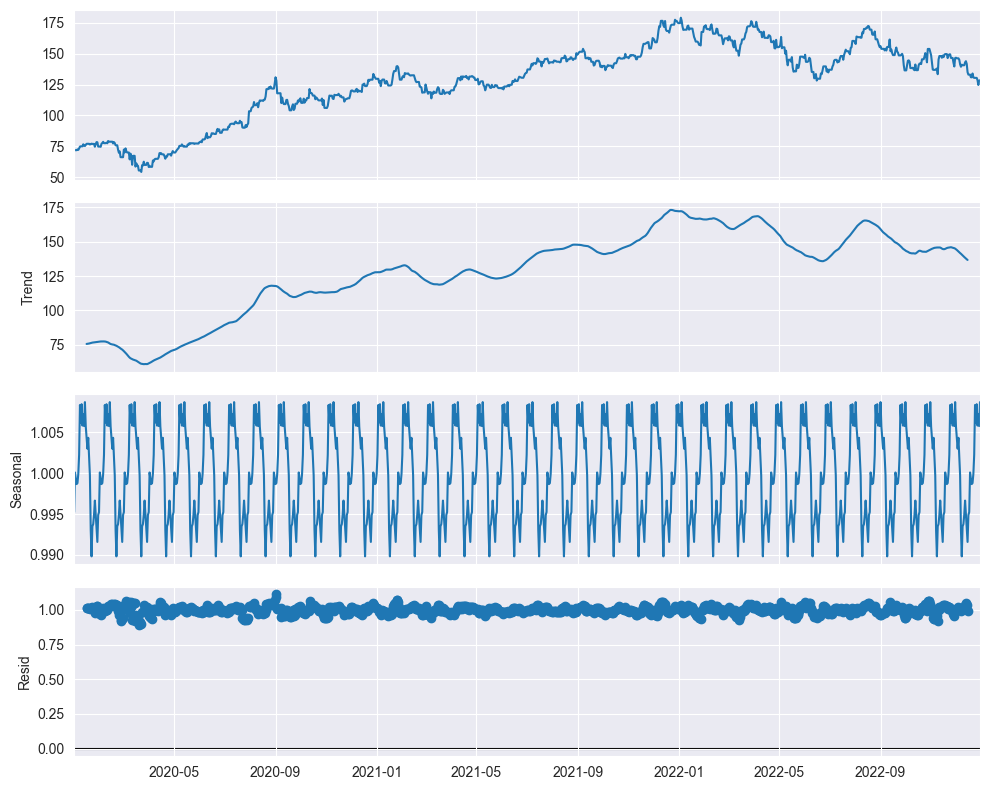

In [4]:
# Celda 4

# Antes de la descomposición, rellenamos los valores NaN para evitar errores
df_ts.fillna(method='ffill', inplace=True)  # Rellena valores faltantes con el último valor conocido

# Descomponemos la serie para observar tendencia, estacionalidad y residuo
# Se usa el modelo 'multiplicative' y un periodo de 30 días (ajustable según el dataset)
result = seasonal_decompose(df_ts['Close'], model='multiplicative', period=30)

# Graficamos los componentes
fig = result.plot()
fig.set_size_inches(10, 8)  # Ajustamos el tamaño del gráfico
plt.tight_layout()  # Ajustamos la disposición para evitar solapamientos
plt.show()


In [5]:
# Celda 5

# ARIMA requiere una serie estacionaria o casi estacionaria.
# Normalmente, podríamos tomar la diferencia de la serie para estabilizar la media.
# Sin embargo, primero haremos un split (entrenamiento/prueba) para evaluar el rendimiento del modelo.

# Definimos un corte (por ejemplo, en el 80% de los datos)
train_size = int(len(df_ts) * 0.8)  # 80% de los datos para entrenamiento
train_data = df_ts.iloc[:train_size].copy()  # Subconjunto de entrenamiento
test_data = df_ts.iloc[train_size:].copy()   # Subconjunto de prueba

print("Tamaño datos de entrenamiento:", len(train_data))
print("Tamaño datos de prueba:", len(test_data))


Tamaño datos de entrenamiento: 875
Tamaño datos de prueba: 219


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  875
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1906.002
Date:                Fri, 14 Feb 2025   AIC                           3818.004
Time:                        23:28:27   BIC                           3832.323
Sample:                    01-02-2020   HQIC                          3823.481
                         - 05-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2350      0.310      0.757      0.449      -0.373       0.843
ma.L1         -0.3214      0.307     -1.046      0.296      -0.924       0.281
sigma2         4.5891      0.135     34.052      0.0

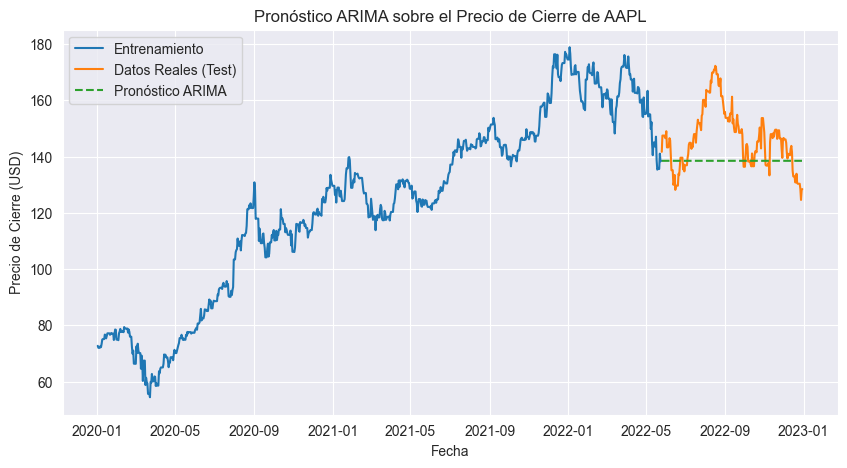

In [6]:
# Celda 6 (modificada)

# Definir los parámetros del modelo ARIMA (p, d, q)
p, d, q = 1, 1, 1  

# Creamos el modelo asegurándonos de que el índice tiene una frecuencia definida
model = ARIMA(train_data['Close'], order=(p, d, q), freq='D')  # Se agrega freq='D' para frecuencia diaria

# Ajustamos el modelo a los datos de entrenamiento
model_fit = model.fit()

# Imprimimos un resumen del modelo entrenado
print(model_fit.summary())

# Realizamos el pronóstico
forecast_steps = len(test_data)  
forecast = model_fit.forecast(steps=forecast_steps)

# Creamos un DataFrame para comparar el pronóstico con los valores reales
forecast_df = test_data.copy()
forecast_df['Predicted_ARIMA'] = forecast.values

# Graficamos los datos reales y la predicción
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['Close'], label='Entrenamiento')
plt.plot(test_data.index, test_data['Close'], label='Datos Reales (Test)')
plt.plot(forecast_df.index, forecast_df['Predicted_ARIMA'], label='Pronóstico ARIMA', linestyle='--')
plt.title('Pronóstico ARIMA sobre el Precio de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()
